In [1]:
from google.colab import drive
import sys
drive.mount("/content/gdrive", force_remount=True)
sys.path.append('/content/gdrive/My Drive/THESIS')
!pip install tensorflow-addons

Mounted at /content/gdrive
     |████████████████████████████████| 706kB 7.8MB/s 


In [2]:
from backend.preprocessing import *
from backend.metrics import *
from backend.gan import GAN
from backend.tcn import make_TCN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from tensorflow.random import normal
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('gdrive/My Drive/THESIS/datasets/dow_adj_close.csv', parse_dates=['Date']).set_index('Date')
log_returns = np.log(df/df.shift(1))[1:].to_numpy()

df.head()

,GS,MMM,IBM,BA,HD,MCD,UNH,TRV,DIS,AAPL,JNJ,RTX,CVX,PG,XOM,V,AXP,WMT,CAT,NKE,JPM,DD,MSFT,MRK,VZ,KO,INTC,PFE,GE,CSCO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,157.529327,112.674896,139.235443,116.807953,69.619453,78.679359,66.484276,75.782288,70.192497,17.598297,74.702354,59.506023,91.164238,64.685707,72.809273,52.564686,79.889244,66.537399,72.248413,36.072746,47.637249,51.261227,32.057323,39.639069,35.055759,32.162357,21.086889,22.159529,22.299896,17.479795
2014-01-03,158.651398,112.935913,140.068451,117.619873,69.509087,78.785431,66.956818,75.638062,70.045273,17.211735,75.375275,59.722923,91.318466,64.613434,72.634109,52.600361,80.148262,66.318146,72.208244,35.975906,48.005512,51.027534,31.841665,39.831303,34.640827,32.004135,21.078712,22.203180,22.283680,17.463903
2014-01-06,159.737869,112.267044,139.588150,118.295074,68.838554,78.222336,66.190048,75.434479,69.778374,17.305593,75.769188,59.664726,91.076134,64.766029,72.743599,52.284039,80.112511,65.947159,71.259575,35.699287,48.283752,50.934059,31.168766,39.839314,34.833996,31.853863,20.817074,22.225004,22.105280,17.487747
2014-01-07,158.776001,112.283340,142.372406,120.089874,69.178085,78.654839,68.213905,74.993355,70.256927,17.181829,77.377640,60.045601,91.847214,65.392487,73.772751,52.683613,79.808891,66.149521,71.492737,35.726944,47.727261,50.373192,31.410315,40.135662,35.270397,31.948786,20.923365,22.363232,22.129606,17.726107
2014-01-08,158.909637,111.451324,141.066589,120.354836,69.543060,77.863258,67.420418,74.297714,69.226189,17.290642,77.270950,60.119633,90.540024,64.444771,73.531898,52.852474,80.059601,65.626755,71.661568,35.542519,48.177376,50.431606,30.849575,39.879356,35.075134,31.592831,20.792542,22.515999,22.064739,17.710211


In [4]:
df_wgt = pd.read_csv('gdrive/My Drive/THESIS/datasets/dow_weight.csv')
wgt = df_wgt['weight'].to_numpy()
df_wgt.head()

,ticker,weight
0,GS,6.74
1,MMM,5.88
2,IBM,5.56
3,BA,5.43
4,HD,5.15


In [5]:
s1 = StandardScaler()

# receptive field size
rfs = 127

# pre-processing pipeline, note the removcal of Gaussianize operation,
# this operation has to be individually applied to all 30 return series,
# due to disrepenencies in mean and variance across return series, 
# complicating the pre-processing reversal process.
log_returns_preprocessed = s1.fit_transform(log_returns)
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

In [6]:
dilations = 2**(np.arange(6))
n_filters = 80

discriminator = make_TCN(dilations, n_filters, False, False, False, [1, rfs, 1])
generator = make_TCN(dilations, n_filters, True, False, False, [1, None, 3])

In [7]:
from tensorflow.keras.utils import Progbar
from tensorflow.random import normal

class multiDataGAN(GAN):
    def train(self, data, batch_size, n_batches, additional_d_steps):
        progress = Progbar(n_batches)

        for n_batch in range(n_batches):

            batch_idx_class = np.random.choice(np.arange(data.shape[3]), p=wgt/100, size=batch_size)
            batch_idx_time = np.random.choice(np.arange(data.shape[0]), size=batch_size, replace=(batch_size > data.shape[0]))
            batch = data[batch_idx_time, ..., batch_idx_class]

            self.train_step(batch, batch_size, additional_d_steps)

            self.train_hook(n_batch)

            progress.update(n_batch + 1)

    def train_hook(self, n_batch):
        if (n_batch + 1) % 500 == 0:
            y = self.generator(self.fixed_noise).numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))
        
gan = multiDataGAN(discriminator, generator, lr_d=3e-4, lr_g=1e-4)

gan.acf_real = np.average(acf(log_returns_preprocessed, 250), axis=1, weights=wgt)
gan.abs_acf_real = np.average(acf(log_returns_preprocessed**2, 250), axis=1, weights=wgt)
gan.le_real = np.average(acf(log_returns_preprocessed, 250, le=True), axis=1, weights=wgt)

gan.fixed_noise = normal([128, 1, 4000 + rfs - 1, 3])

In [8]:
data = np.expand_dims(np.moveaxis(log_returns_rolled, 0, 1), 1)
batch_size = 512
n_batches = 1000
additional_d_steps = 0

gan.train(data, batch_size, n_batches, additional_d_steps)

 499/1000 [=============>................] - ETA: 4:33
acf: 0.2263, acf_abs: 0.1933, le: 0.1751
 999/1000 [============================>.] - ETA: 0s
acf: 0.2158, acf_abs: 0.1715, le: 0.1914
1000/1000 [==============================] - 576s 562ms/step


In [9]:
gan.save('/content/gdrive/My Drive/THESIS/trained_generator_dow_jones')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/THESIS/trained_generator_dow_jones/assets


In [10]:
noise = normal([1000, 1, len(log_returns_preprocessed) + rfs - 1, 3])

# fit a StandardScaler on a dow jones weighted average to inverse transform
s2 = StandardScaler().fit(np.expand_dims(np.average(log_returns, weights=wgt, axis=1), 1))

y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

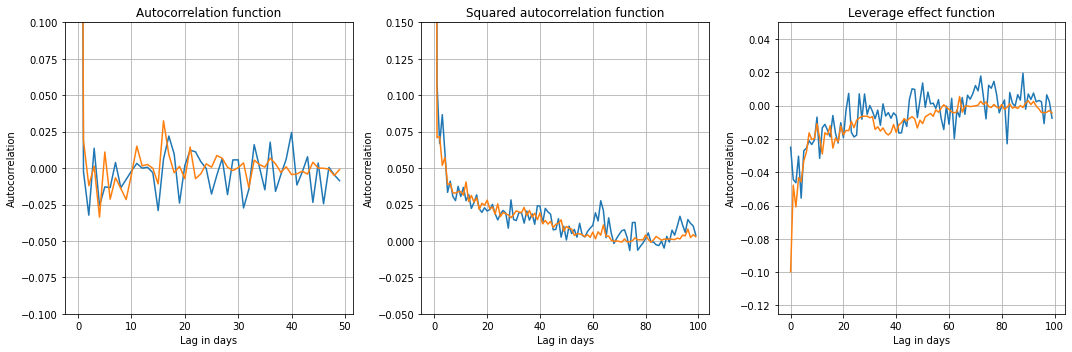

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 50).mean(axis=1))
axs[0].plot(acf(y.T, 50).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_title('Autocorrelation function')
axs[1].plot(acf(log_returns**2, 100).mean(axis=1))
axs[1].set_ylim(-0.05, 0.15)
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared autocorrelation function')
axs[2].plot(acf(log_returns, 100, le=True).mean(axis=1))
axs[2].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[2].set_ylim(-0.125, 0.05)
axs[2].set_title('Leverage effect function')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='Lag in days', ylabel='Autocorrelation');

fig.tight_layout();

In [12]:
def clustering(real_returns, synth_returns, window_length, n_clusters, random_state=0):

    real_samples = rolling_window(real_returns, window_length).T.reshape((-1, window_length))
    # We cluster based on synth samples, so we skip ahead twice the window length
    # to avoid interdependencies of windows
    synth_samples = rolling_window(synth_returns, window_length)[:, ::window_length*2].T.reshape((-1, window_length))
    
    kmeans = KMeans(n_clusters=30, random_state=random_state)
    kmeans.fit(synth_samples)

    real_bins = kmeans.predict(real_samples)
    synth_bins = kmeans.predict(synth_samples)

    real_freq = np.bincount(real_bins)
    synth_freq = np.bincount(synth_bins)

    total_freq = np.stack([real_freq, synth_freq])
    total_freq = total_freq / total_freq.sum(axis=1, keepdims=True)

    return real_samples, synth_samples, real_bins, synth_bins, total_freq.T

def plot_clustering(synth_samples, synth_bins, total_freq, alpha, bins):
    fig, ax = plt.subplots(figsize=(20,12), nrows=3, ncols=3, sharex=True, sharey=True)

    i = 0
    j = 0
    for bin in bins:
        ax[i, j].plot(np.moveaxis(synth_samples[synth_bins == bin], 0, -1), color='orange', alpha=alpha)
        ax[i, j].set_title('# paths: {}'.format(int((synth_bins == bin).sum())))
        ax[i, j].grid(axis='y', which='major')

        j += 1
        j = j % 3
        if j == 0:
            i += 1

    plt.setp(ax[-1, :], xlabel='days elapsed')
    plt.setp(ax[:, 0], ylabel='daily log return')

    return fig, ax

In [13]:
real_samples, synth_samples, real_bins, synth_bins, total_freq = clustering(log_returns, y.T, 16, 30)

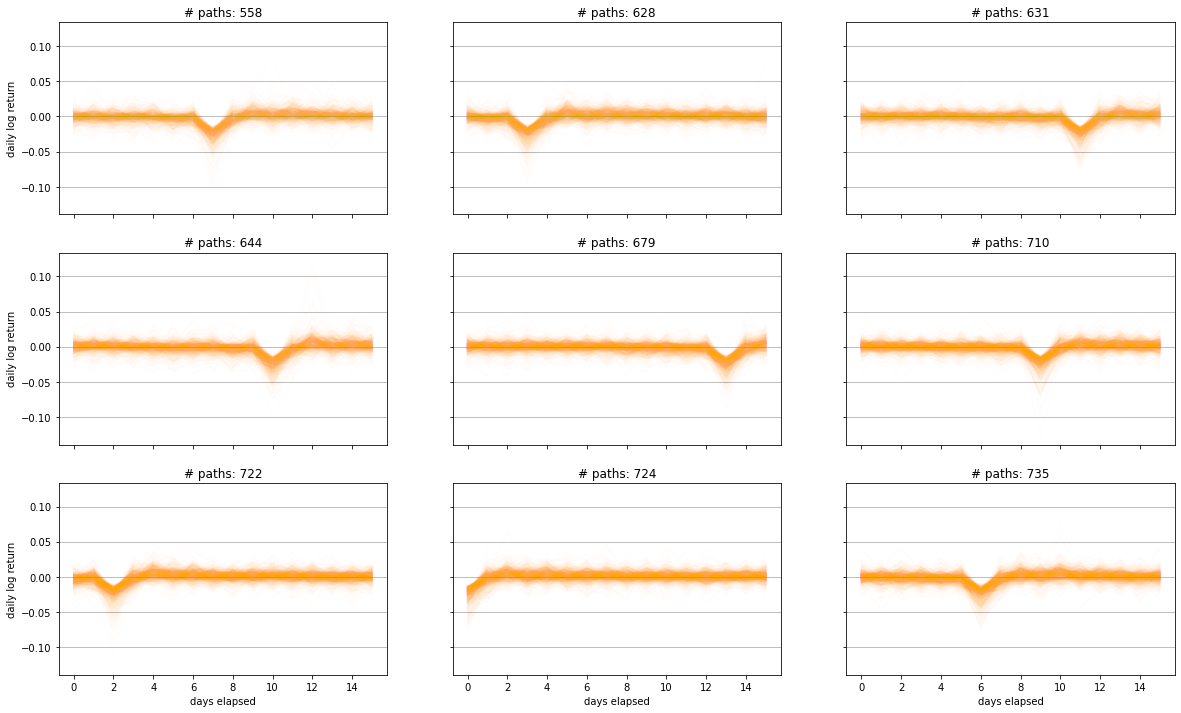

In [14]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, total_freq, 0.01, small_bins);

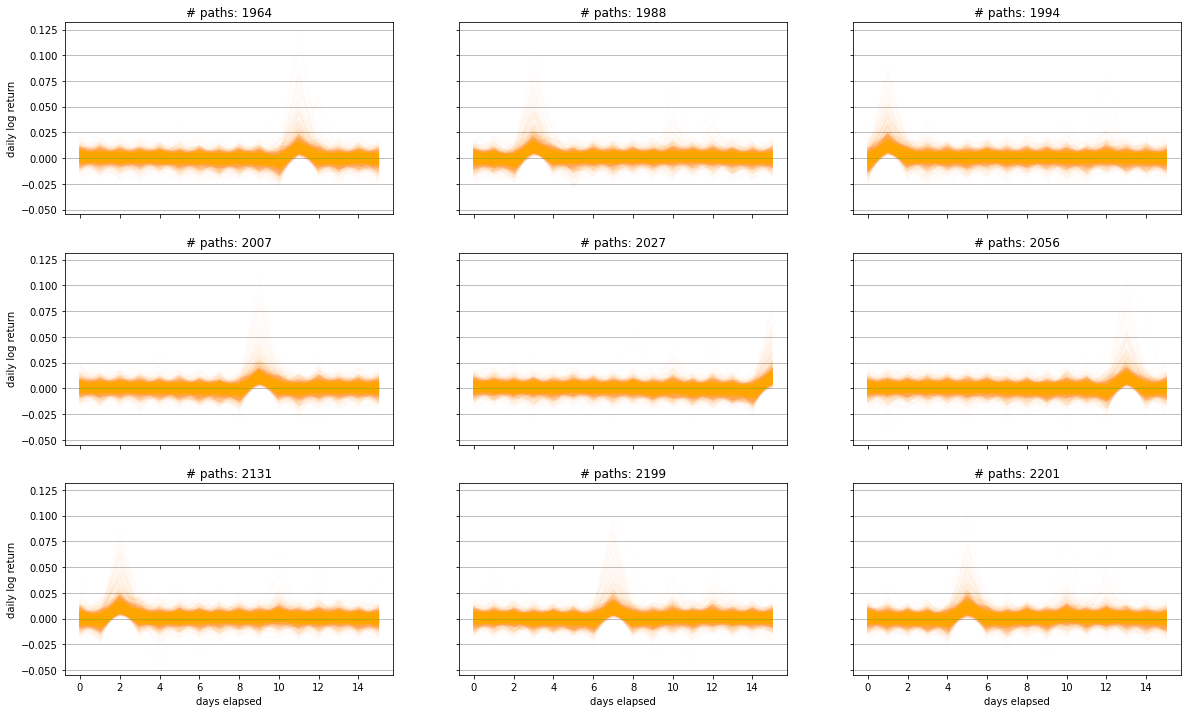

In [15]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, total_freq, 0.01, big_bins);

In [16]:
real_samples, synth_samples, real_bins, synth_bins, total_freq = clustering(log_returns, y.T, 127, 30)

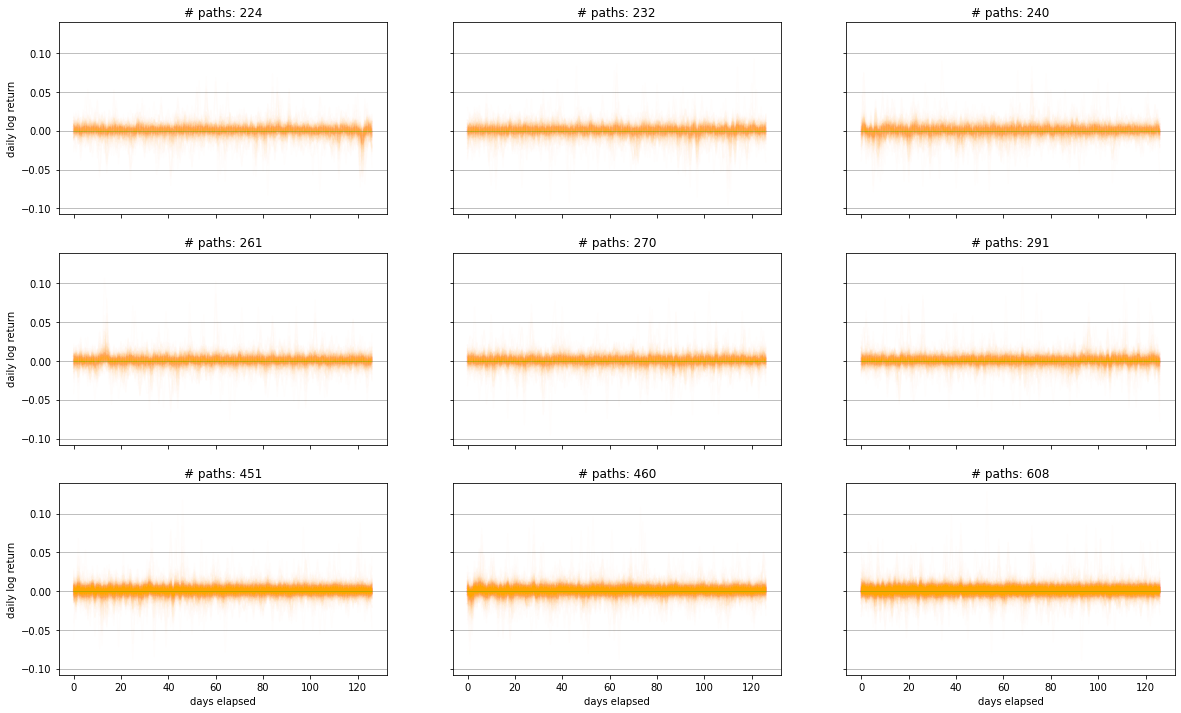

In [17]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, total_freq, 0.01, big_bins);